In [462]:
import geopandas as gpd
import numpy as np
from typing import *
import json

In [463]:
import requests
from io import BytesIO
import zipfile
import time

def get_file_name(latitude: float, longitude: float) -> Optional[str]:
    # from SRTM.py
    # return filename ex: N45W074.hgt
    if latitude >= 0:
        north_south = 'N'
    else:
        north_south = 'S'

    if longitude >= 0:
        east_west = 'E'
    else:
        east_west = 'W'

    file_name = '%s%s%s%s.hgt' % (north_south, str(int(abs(np.floor(latitude)))).zfill(2),
                                  east_west, str(int(abs(np.floor(longitude)))).zfill(3))
    return file_name



def fetch_data(url: str) -> None:
    # URL of the .zip file
    try:
        response = requests.get(url)
        buffer = BytesIO(response.content)
        with zipfile.ZipFile(buffer, "r") as zip_ref:
            zip_ref.extractall('temp')
            print('file save to temp/')
    except:
        time.sleep(2)
        response = requests.get(url)
        buffer = BytesIO(response.content)
        with zipfile.ZipFile(buffer, "r") as zip_ref:
            zip_ref.extractall('temp')
            print('file save to temp/')
    



In [464]:
import numpy as np

from scipy import interpolate

def read_hgt_file(hgt_file, arc=3):

    SAMPLES = int(3600/arc +1)

    filename = hgt_file.split('/')[-1]

    if filename.split('S')[0] != filename: lat0 = -int(filename.split('S')[-1][0:2])
    if filename.split('N')[0] != filename: lat0 =  int(filename.split('N')[-1][0:2])
    if filename.split('W')[0] != filename: lon0 = -int(filename.split('W')[-1][0:3])
    if filename.split('E')[0] != filename: lon0 =  int(filename.split('E')[-1][0:3])

    lat = np.linspace(lat0, lat0 + 1, SAMPLES)
    lon = np.linspace(lon0, lon0 + 1, SAMPLES)

    with open(hgt_file, 'rb') as hgt_data:
        # Each data is 16bit signed integer(i2) - big endian(>)
        elevation = np.fromfile(hgt_data, np.dtype('>i2'), SAMPLES*SAMPLES)\
                                .reshape((SAMPLES, SAMPLES))
        return np.flip(elevation,axis=0).T, lat, lon
    
    
from scipy.interpolate import RegularGridInterpolator
def interpolate_elevation(gps_track, alt, lon, lat):
    x = gps_track.x
    y = gps_track.y

    interp = RegularGridInterpolator((lon, lat), alt, bounds_error=False, fill_value=None)

    return [ int(interp(tup)) for tup in zip(x,y)]

In [486]:
srtm = 'srtm3'

arc_dict= {'srtm1':1,'srtm3':3}

In [487]:
df = gpd.read_file('test/nodes4.geojson')
df = df.set_index('index')

In [488]:
# lon is est west
# lat is north south
lonlat_list = [ list((geom.xy[0][0], geom.xy[1][0])) for geom in df['geometry'].values ]
df[['lon','lat']] = lonlat_list

In [489]:
df['file_name'] = df.apply(lambda x: get_file_name(x['lat'],x['lon']),axis=1)
df

,stop_code,stop_name,route_width,geometry,lon,lat,file_name
index,,,,,,,
node_t5fF1w3BxHZbTXvhag8Duy,NaN,NaN,3,POINT (-79.47327 44.27277),-79.473273,44.272773,N44W080.hgt
node_n1mt2axQTagJ8HqN3Am2PR,NaN,NaN,3,POINT (-79.45404 44.16743),-79.454041,44.167433,N44W080.hgt
node_wFdw3xcQdvatw3kYK26j8w,NaN,NaN,3,POINT (-79.40733 44.01352),-79.407335,44.013516,N44W080.hgt
node_fBm7WsfhSxZyz7NMzXbeVE,NaN,NaN,3,POINT (-79.37711 43.89485),-79.377114,43.894845,N43W080.hgt
node_xkqAJ1VpXPdzBinWDNy6ap,NaN,NaN,3,POINT (-79.37162 43.80767),-79.371619,43.807669,N43W080.hgt
node_7Yw4z4edaiLya89AGQSyrd,NaN,NaN,3,POINT (-79.33316 43.69554),-79.333155,43.695541,N43W080.hgt
node_qf5NyuH4EPFfP9TLcpNw57,NaN,NaN,3,POINT (-79.49937 43.65481),-79.499373,43.654806,N43W080.hgt
node_mG6JbTyfqBrfQdgvxdsWHU,NaN,NaN,3,POINT (-79.65735 43.58519),-79.657349,43.585193,N43W080.hgt
node_jsHC4W7smyonhK2cjxYK1G,NaN,NaN,3,POINT (-79.72191 43.46667),-79.721913,43.466667,N43W080.hgt


In [490]:
# Open the JSON file
with open('url_list.json') as file:
    data = json.load(file)
data[srtm]['N44W080.hgt']

'https://srtm.kurviger.de/SRTM3//North_America//N44W080.hgt.zip'

In [491]:
files = list(df['file_name'].unique())

In [492]:
el_dict = {}
for file in files:

    temp_df = df[df['file_name']==file].copy()

    url = data[srtm][file]

    fetch_data(url)

    alt, lat, lon = read_hgt_file('temp/{f}'.format(f=file),arc_dict[srtm])

    temp_df['elevation'] = interpolate_elevation(temp_df['geometry'], alt, lon, lat)
    
    el_dict.update(temp_df['elevation'].to_dict())

df['elevation'] = df.index.map(el_dict.get)


file save to temp/
file save to temp/


<Axes: xlabel='index'>

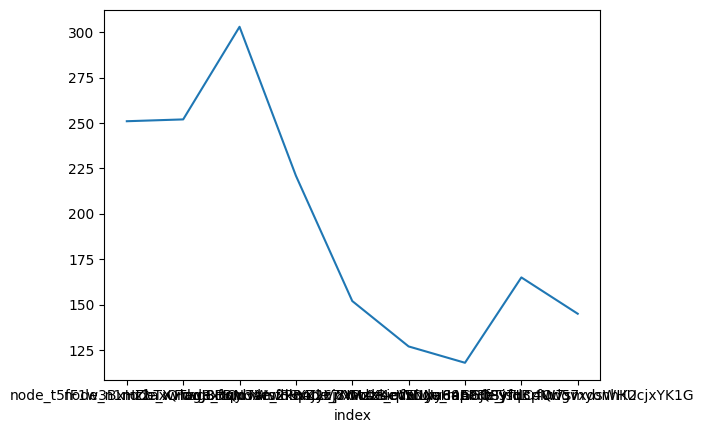

In [493]:
df['elevation'].plot()

In [509]:
[get_elevation(n) for n in nodes_list]

[250, 253, 302, 223, 151, 127, 116, 165, 147]

In [510]:
df

,stop_code,stop_name,route_width,geometry,lon,lat,file_name,elevation
index,,,,,,,,
node_t5fF1w3BxHZbTXvhag8Duy,NaN,NaN,3,POINT (-79.47327 44.27277),-79.473273,44.272773,N44W080.hgt,251
node_n1mt2axQTagJ8HqN3Am2PR,NaN,NaN,3,POINT (-79.45404 44.16743),-79.454041,44.167433,N44W080.hgt,252
node_wFdw3xcQdvatw3kYK26j8w,NaN,NaN,3,POINT (-79.40733 44.01352),-79.407335,44.013516,N44W080.hgt,303
node_fBm7WsfhSxZyz7NMzXbeVE,NaN,NaN,3,POINT (-79.37711 43.89485),-79.377114,43.894845,N43W080.hgt,221
node_xkqAJ1VpXPdzBinWDNy6ap,NaN,NaN,3,POINT (-79.37162 43.80767),-79.371619,43.807669,N43W080.hgt,152
node_7Yw4z4edaiLya89AGQSyrd,NaN,NaN,3,POINT (-79.33316 43.69554),-79.333155,43.695541,N43W080.hgt,127
node_qf5NyuH4EPFfP9TLcpNw57,NaN,NaN,3,POINT (-79.49937 43.65481),-79.499373,43.654806,N43W080.hgt,118
node_mG6JbTyfqBrfQdgvxdsWHU,NaN,NaN,3,POINT (-79.65735 43.58519),-79.657349,43.585193,N43W080.hgt,165
node_jsHC4W7smyonhK2cjxYK1G,NaN,NaN,3,POINT (-79.72191 43.46667),-79.721913,43.466667,N43W080.hgt,145


In [503]:
import srtm
def get_elevation(lnglat):
    elevation_data = srtm.get_data(srtm1=False)
    return elevation_data.get_elevation(latitude=lnglat[1], longitude=lnglat[0])

In [505]:
nodes_list = [ tuple((geom.xy[0][0], geom.xy[1][0])) for geom in df['geometry'].values ]


4 2884802


[250, 253, 302, 223, 151, 127, 116, 165, 147]

In [496]:
interp = RegularGridInterpolator((lon, lat), alt, bounds_error=False, fill_value=None)

interp((-74,45))

array(7217051.00001335)

In [497]:
import random
i=random.randint(0,len(lon))
j=random.randint(0,len(lat))

In [498]:
print((lon[i],lat[j]))
print(alt[i,j],int(interp((lon[i],lat[j]))))


(-79.68833333333333, 43.14416666666666)
198 198


In [499]:
i=-1
j=-1
print((lon[i],lat[j]))
print(alt[i,j],int(interp((lon[i],lat[j]))))

(-79.0, 44.0)
251 251


In [500]:
alt

array([[208, 209, 207, ..., 320, 313, 305],
       [209, 208, 208, ..., 319, 316, 309],
       [211, 210, 208, ..., 316, 312, 314],
       ...,
       [183, 183, 185, ..., 247, 246, 249],
       [182, 183, 188, ..., 246, 246, 249],
       [184, 183, 188, ..., 244, 247, 251]], dtype=int16)

In [501]:
np.flip(alt,axis=0)

array([[184, 183, 188, ..., 244, 247, 251],
       [182, 183, 188, ..., 246, 246, 249],
       [183, 183, 185, ..., 247, 246, 249],
       ...,
       [211, 210, 208, ..., 316, 312, 314],
       [209, 208, 208, ..., 319, 316, 309],
       [208, 209, 207, ..., 320, 313, 305]], dtype=int16)

In [502]:
def read_hgt_file(hgt_file, arc=3):

    SAMPLES = int(3600/arc +1)

    filename = hgt_file.split('/')[-1]

    if filename.split('S')[0] != filename: lat0 = -int(filename.split('S')[-1][0:2])
    if filename.split('N')[0] != filename: lat0 =  int(filename.split('N')[-1][0:2])
    if filename.split('W')[0] != filename: lon0 = -int(filename.split('W')[-1][0:3])
    if filename.split('E')[0] != filename: lon0 =  int(filename.split('E')[-1][0:3])

    lat = np.linspace(lat0, lat0 + 1, SAMPLES)
    lon = np.linspace(lon0, lon0 + 1, SAMPLES)

    with open(hgt_file, 'rb') as hgt_data:
        # Each data is 16bit signed integer(i2) - big endian(>)
        elevation = np.fromfile(hgt_data, np.dtype('>i2'), SAMPLES*SAMPLES)\
                                .reshape((SAMPLES, SAMPLES))
        return np.flip(elevation,axis=0).T, lat, lon
alt, lat, lon = read_hgt_file('temp/{f}'.format(f=file),arc_dict[srtm])
alt

array([[208, 209, 207, ..., 320, 313, 305],
       [209, 208, 208, ..., 319, 316, 309],
       [211, 210, 208, ..., 316, 312, 314],
       ...,
       [183, 183, 185, ..., 247, 246, 249],
       [182, 183, 188, ..., 246, 246, 249],
       [184, 183, 188, ..., 244, 247, 251]], dtype=int16)